# <center> Two-element POVM as a quantum version of the classifier </center>

In [1]:
import pennylane as qml
from pennylane import numpy as np

from sympy import * 
from sympy.physics.quantum.circuitplot import CircuitPlot,labeller,Mz,CreateOneQubitGate
from sympy.physics.quantum.gate import *
from sympy.physics.quantum.qasm import Qasm

from matplotlib import rc
#rc('text',usetex=True)

In [2]:
dev = qml.device('default.qubit', wires=2)
#dev = qml.device('qiskit.aer', wires=2)
#dev = qml.device('qiskit.ibmq', wires=2, shots=8192, ibmqx_token="e942e97ce86ca8c3609a4053fe6762ec3db17c41895b2d85d6a3560a1156501d57db36753f99138ecb32dca58a97ae5b38005ad39855dd92ab0e86cef852c1a2")

---
## Preparing arbitrary pure states in the quantum circuit

A pure state: $|\psi\rangle = \cos(\theta/2)|0\rangle + e^{i\phi}\sin(\theta/2)|1\rangle$, where $0\le\theta\le\pi$  and $0\le\phi\le 2\pi$.

$ U = R_z(\beta)R_y(\gamma)R_z(\delta) = \begin{bmatrix} e^{-i(\delta+\beta)/2}\cos(\gamma/2) & -e^{i(\delta-\beta)/2}\sin(\gamma/2) \\ e^{-i(\delta-\beta)/2}\sin(\gamma/2) & e^{i(\delta+\beta)/2}\cos(\gamma/2) \end{bmatrix} $

Block vector $\vec{a}=(\sin \theta \cos \phi, \sin \theta \sin \phi, \cos \theta)$.

In [3]:
#@qml.qnode(dev)
def state_preparation(statevector, wire):
    # input: state_vec
    if statevector[0] < 0:
        raise ValueError("The amplitude in state |0> doesn't have to be nonnegative.")
    theta = 2 * np.arccos(statevector[0])
    
    phi = np.angle(statevector[1]/np.sin(theta/2)) if not np.isclose(np.sin(theta/2), 0) else 0
    # input: bloch_vec

    qml.Rot(phi, theta, (-1)*phi, wires=wire)
    #return qml.state()

#### Test and Drawing `state_preparation` module

In [4]:
@qml.qnode(dev)
def test_initstate(test_vec):    
    state_preparation(test_vec, wire=0)
    return qml.state()

test_vec = [1/np.sqrt(2), -1/np.sqrt(2)]
print(test_initstate(test_vec))

print(test_initstate.draw())

[ 0.70710678+0.00000000e+00j  0.        +0.00000000e+00j
 -0.70710678-8.65956056e-17j  0.        +0.00000000e+00j]
 0: ──Rot(3.14, 1.57, -3.14)──┤ State 



---
## Two-element POVM Module.

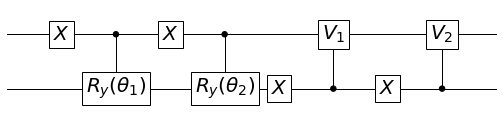

In [5]:
Ry1 = CreateOneQubitGate('Ry1', r'R_y(\theta_1)')
Ry2 = CreateOneQubitGate('Ry2', r'R_y(\theta_2)')
V1 = CreateOneQubitGate('V1', r'V_1')
V2 = CreateOneQubitGate('V2', r'V_2')

CircuitPlot(CGate(0,V2(1))*X(0)*CGate(0,V1(1))*X(0)*CGate(1,Ry2(0))*X(1)*CGate(1,Ry1(0))*X(1),2)

In [6]:
def two_element_povm(params, wires):
    #params 

    # Controlled-RY gate controlled by first qubit in |0> state
    qml.PauliX(wires=wires[0])
    qml.CRY(params[0], wires=[wires[0],wires[1]])
    qml.PauliX(wires=wires[0])
    
    # Controlled-RY gate controlled by first qubit in |1> state
    qml.CRY(params[1], wires=[wires[0],wires[1]])
    
    # Controlled-Rotation gate (arbitrary single-qubit unitary operator) controlled by 2nd qubit in |0> state
    qml.PauliX(wires=wires[1])
    qml.CRot(params[2], params[3], params[4], wires=[wires[1],wires[0]])
    qml.PauliX(wires=wires[1])

    # # Controlled-Rotation gate (arbitrary single-qubit unitary operator) controlled by 2nd qubit in |1> state
    qml.CRot(params[5], params[6], params[7], wires=[wires[1],wires[0]])

#### Test and Drawing `two_element_povm` module

In [7]:
@qml.qnode(qml.device('default.qubit', wires=2))
def povm_circuit(params):
    two_element_povm(params, wires=[0, 1])
    return qml.expval(qml.Identity(0) @ qml.PauliZ(1))

# initial parameters
params = np.random.random([8])
povm_circuit(params)

print("Drawing a two-element POVM circuit : ")
print(povm_circuit.draw())

Drawing a two-element POVM circuit : 
 0: ──X──╭C──────────X──╭C─────────────╭Rot(0.955, 0.248, 0.38)─────╭Rot(0.324, 0.112, 0.168)──╭┤ ⟨I ⊗ Z⟩ 
 1: ─────╰RY(0.337)─────╰RY(0.235)──X──╰C────────────────────────X──╰C─────────────────────────╰┤ ⟨I ⊗ Z⟩ 



---
## Minimum Error Discrimination

Preparation: $\{q_i,\hat{\rho}_i\}^{n}_{i=1}$ $\longleftarrow$ $\hat{\rho} = \sum_i q_i\hat{\rho}_i$. <br>

POVMs: $\{E_k\}_{k=0}^{l-1}$ with $\sum_{k=0}^{l-1} E_k = I$.

In general, for a state $\hat{\rho}_i$ generated in preparation, a detection event on $\hat{E}_k$ happens with probability $ p_{k|i} = \text{Tr} [\hat{E}_k\hat{\rho_i}] $.

$$
p_{error} = 1 - p_{guess} = 1-\max_{\{E_i\}}\left( \sum_{i=0}^{l-1} q_ip_{i|i} \right)
$$

---
## Optimal POVM for State Discrimination

#### Probability: $p(k)=\text{Tr}[(I\otimes |k\rangle\langle k|)\cdot (|\psi_i\rangle\langle\psi_i|)]= \langle \psi_k|\hat{K}^\dagger_k\hat{K}_k|\psi_k\rangle = \text{Tr}[\hat{E}_k\hat{\rho}_k]$

In [8]:
@qml.qnode(dev)
def circuit_povm_probs(init_state, params):
    state_preparation(init_state, wire=0)

    # arbitrary rotation
    qml.Rot(params[0], params[1], params[2], wires=0)

    # two-element POVM
    two_element_povm(params[3:], wires=[0, 1])

    #qml.CNOT(wires=[2,1])

    return qml.probs(wires=[1])

In [10]:
params = 4 * np.pi * np.random.random([19])
circuit_povm_probs([1,0] , params)

tensor([0.66539634, 0.33460366], requires_grad=True)

#### Cost function: $C(\vec{\theta}) = 1 - \text{Tr}[\hat{E}_0\hat{\rho}_0] - \text{Tr}[\hat{E}_1\hat{\rho}_1]$

In [39]:
def cost(x):
    #psi0 = [1, 0]
    psi0 = [1/np.sqrt(2), 1j/np.sqrt(2)]
    #psi1 = [1/np.sqrt(2), -1j/np.sqrt(2)]
    psi1 = [np.sqrt(3)/2,-1j/2]

    prob0 = circuit_povm_probs(psi0, x)[0]
    prob1 = circuit_povm_probs(psi1, x)[1]

    q0 = 1/2
    q1 = 1/2

    res = 1 - (q0 * prob0 + q1 * prob1)
    return res


In [40]:
# initialise the optimizer
opt = qml.GradientDescentOptimizer(stepsize=0.4)

# set the number of steps
steps = 120

# set the initial parameter values
params = 4 * np.pi * np.random.random([11])
print("cost(init_params) =", cost(params))

for i in range(steps):
    # update the circuit parameters
    params = opt.step(cost, params)

    if (i+1) % 5 == 0:
        print("Cost after step {:5d}: {: .7f}".format(i + 1, cost(params)))

print("Optimized rotation angles: {}".format(params))

cost(init_params) = 0.5008252404490936
Cost after step     5:  0.4247828
Cost after step    10:  0.2952042
Cost after step    15:  0.1458477
Cost after step    20:  0.0628499
Cost after step    25:  0.0327667
Cost after step    30:  0.0225819
Cost after step    35:  0.0190251
Cost after step    40:  0.0177546
Cost after step    45:  0.0172966
Cost after step    50:  0.0171310
Cost after step    55:  0.0170711
Cost after step    60:  0.0170494
Cost after step    65:  0.0170415
Cost after step    70:  0.0170387
Cost after step    75:  0.0170377
Cost after step    80:  0.0170373
Cost after step    85:  0.0170372
Cost after step    90:  0.0170371
Cost after step    95:  0.0170371
Cost after step   100:  0.0170371
Cost after step   105:  0.0170371
Cost after step   110:  0.0170371
Cost after step   115:  0.0170371
Cost after step   120:  0.0170371
Optimized rotation angles: [ 4.71238898 11.25737368  9.49321424  3.14161155  6.2831726  10.99620734
  7.33017394 10.91780961  0.79706633  6.35017

---
## Calculating Kraus Operators $\{K_i\}$ and POVMs $\{\hat{E}_i\}$.

### Arbitrary rotation of the single qubit
### $$ U = R_z(\beta)R_y(\gamma)R_z(\delta) = \begin{bmatrix} e^{-i(\delta+\beta)/2}\cos(\gamma/2) & -e^{i(\delta-\beta)/2}\sin(\gamma/2) \\ e^{-i(\delta-\beta)/2}\sin(\gamma/2) & e^{i(\delta+\beta)/2}\cos(\gamma/2) \end{bmatrix}$$

### Y-Rotation of the single qubit
### $$ R_y(\phi) = e^{-i\phi\sigma_y/2} = \begin{bmatrix} \cos\phi/2 & -\sin\phi/2 \\ \sin\phi/2 & \cos\phi/2 \end{bmatrix} $$

In [41]:
def unitaries_in_povm(params):
    U = qml.Rot(params[0], params[1], params[2], wires=2).matrix
    Ry0 = qml.RY(params[3], wires=2).matrix
    Ry1 = qml.RY(params[4], wires=2).matrix
    V0 = qml.Rot(params[5], params[6], params[7], wires=2).matrix
    V1 = qml.Rot(params[8], params[9], params[10], wires=2).matrix

    return U, Ry0, Ry1, V0, V1

U, Ry0, Ry1, V0, V1 = unitaries_in_povm(params)

$$
\hat{K}_0 = V_0D_0U \\
\hat{K}_1 = V_1D_1U 
$$

In [42]:
def kraus_op(params):
    U, _, _, V0, V1 = unitaries_in_povm(params)
    D0 = np.diag([np.cos(params[3]/2), np.cos(params[4]/2)])
    D1 = np.diag([np.sin(params[3]/2), np.sin(params[4]/2)])
    K0 = np.dot(np.dot(V0, D0), U)
    K1 = np.dot(np.dot(V1, D1), U)

    return K0, K1

In [43]:
K0, K1 = kraus_op(params)

print("K0 =", K0)
print("K1 =", K1)

K0 = [[-0.23039094+0.19883118j -0.25911229-0.30026078j]
 [-0.37442608-0.37118966j  0.48373791-0.48796664j]]
K1 = [[ 0.77393077+0.17243757j  0.13231624-0.59385809j]
 [-0.02349126-0.01241486j -0.00951845+0.01802374j]]


$ \hat{K}^\dagger_0\hat{K}_0 + \hat{K}^\dagger_1\hat{K}_1 = I$

In [44]:
E0 = np.dot(K0.conj().T, K0) 
E1 = np.dot(K1.conj().T, K1)
print("E0 =", E0)
print("E1 =", E1)
print("E0 + E1 =", E0 + E1)

E0 = [[3.70590478e-01+0.j         6.43129439e-11+0.48296291j]
 [6.43129439e-11-0.48296291j 6.29409523e-01+0.j        ]]
E1 = [[ 6.29409522e-01+0.j         -6.43129439e-11-0.48296291j]
 [-6.43129439e-11+0.48296291j  3.70590477e-01+0.j        ]]
E0 + E1 = [[1.+0.j 0.+0.j]
 [0.+0.j 1.+0.j]]


$ \langle \psi_0 |\hat{K}^\dagger_0\hat{K}_0|\psi_0\rangle$

In [49]:
res = np.dot(K1, np.array([1/np.sqrt(2), 1j/np.sqrt(2)]))
np.dot(res.conj(),res)

(0.9829629130688277+0j)

$ \langle \psi_1 |\hat{K}^\dagger_1\hat{K}_1|\psi_1\rangle$

In [50]:
#res = np.dot(K1, np.array([1/np.sqrt(2),-1j/np.sqrt(2)]))
res = np.dot(K0, np.array([np.sqrt(3)/2,-1j/2]))
np.dot(res.conj(),res)

(0.8535533906028707+0j)

---
## Helstrom Bound

Note <br>
$q_0\text{Tr}[\hat{\rho}_0\hat{E}_0] + q_1\text{Tr}[\hat{\rho}_1\hat{E}_1]$ <br>
$=\text{Tr}[q_1\hat{\rho}_1 + \hat{E}_0(q_0\hat{\rho}_0-q_1\hat{\rho}_1)]$ <br>
$=\text{Tr}[q_0\hat{\rho}_0 - \hat{E}_1(q_0\hat{\rho}_0-q_1\hat{\rho}_1)]$ <br>
$=\frac{1}{2} + \frac{1}{2}\text{Tr}[(\hat{E}_0-\hat{E}_1)\Lambda] $,
where $\Lambda := q_0\hat{\rho}_0-q_1\hat{\rho}_1$.

$$
\min_E C(\vec{\theta}) = \min_E \left(1 - \text{Tr}[q_0\hat{\rho}_0\hat{E}_0] - \text{Tr}[q_1\hat{\rho}_1\hat{E}_1]\right) \\
= \min_E\left(1 - \frac{1}{2} - \frac{1}{2}\text{Tr}[(\hat{E}_0-\hat{E}_1)\Lambda]\right)\\
= \frac{1}{2} - \frac{1}{2}\max_{E} \text{Tr}[(\hat{E}_0-\hat{E}_1)\Lambda] = \frac{1}{2} - \frac{1}{2}\text{Tr}|\Lambda|
$$

***Spectral Decomposition***: $\Lambda = \lambda_+|\lambda_+\rangle\langle\lambda_+| + \lambda_-|\lambda_-\rangle\langle\lambda_-|$ <br>
<br>
$\hat{E}_0-\hat{E}_1 = |\lambda_+\rangle\langle\lambda_+| - |\lambda_-\rangle\langle\lambda_-|$ gives rise to the maximum.

In [32]:
def spectral_decomp(q1, q2, rho1, rho2):
    w, v = np.linalg.eig(q1*rho1 - q2*rho2)

    return w, v

In [33]:
rho1, rho2 = np.array([[1, 0], [0, 0]]), np.array([[1/2, -1/2], [-1/2, 1/2]])

q1, q2 = 1/2, 1/2
#rho1 = np.array([[1/2, 1/2], [1/2, 1/2]])
#rho2 = np.array([[0, 0], [0, 1]])

w, v = spectral_decomp(q1, q2, rho1, rho2)

In [34]:
print("min of cost function: ", (1 - np.sum(np.abs(w)))/2)
print("E0 =", np.tensordot(v[:,0],v[:,0], axes=0))
print("E1 =", np.tensordot(v[:,1],v[:,1], axes=0))

min of cost function:  0.14644660940672627
E0 = [[0.85355339 0.35355339]
 [0.35355339 0.14644661]]
E1 = [[ 0.14644661 -0.35355339]
 [-0.35355339  0.85355339]]


---
## PGM

---
## povm_clf.py test

In [56]:
from povm_clf import *
import pennylane as qml
import matplotlib.pyplot as plt 

In [60]:
devs = [qml.device('default.qubit', wires=2), qml.device('default.qubit', wires=2)]
wires = [0, 1]
init_states = [[1/np.sqrt(2), 1j/np.sqrt(2)], [np.sqrt(3)/2,-1j/2]]
bloch_vecs = [state_2_bloch(init_states[i]) for i in range(2)]
a_priori_probs = [1/2, 1/2]

In [66]:
classifier = POVM_clf(2, wires, devs, a_priori_probs, bloch_vecs)
cost_list = classifier.run_opt(steps=100)

Cost(init_params)    :  0.5064867
Cost after step    20:  0.4441581
Cost after step    40:  0.2400020
Cost after step    60:  0.0196314
Cost after step    80:  0.0170778
Cost after step   100:  0.0170378


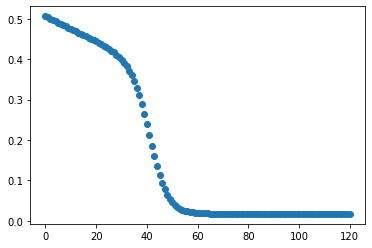

In [65]:
plt.plot(list(range(101)), cost_list, 'o')
plt.show()

In [68]:
rho = classifier.density_matrices
K = classifier.kraus_op()
E = classifier.povm()
med_povm = 1 - (1/2)*np.sum([np.real(np.trace(np.dot(rho[i],E[i]))) for i in range(2)], axis=0)
pgm, med_pgm = classifier.pgm()
print("Minimum-Error Discrimination")
print("performed optimal POVM:", med_povm)
print("performed PGM:", med_pgm)

classifier.res_table()

Minimum-Error Discrimination
performed optimal POVM: 0.9182567680721054
performed PGM: 0.0170370868554659


,rho_i,,E_i,,Tr[rho_i.E_i],PGM_i,,Tr[rho_i.PGM_i]
i=0,0.5000+0.0000j,0.0000-0.5000j,0.3706+0.0000j,0.0000+0.4830j,,0.3706+0.0000j,0.0000-0.4830j,
,0.0000+0.5000j,0.5000+0.0000j,0.0000-0.4830j,0.6294+0.0000j,0.0170,0.0000+0.4830j,0.6294+0.0000j,0.9830
i=1,0.7500+0.0000j,0.0000+0.4330j,0.6294+0.0000j,-0.0000-0.4830j,,0.6294-0.0000j,-0.0000+0.4830j,
,0.0000-0.4330j,0.2500+0.0000j,-0.0000+0.4830j,0.3706+0.0000j,0.1464,-0.0000-0.4830j,0.3706-0.0000j,0.9830


---
## To Do

Write and Read further about optimization...
1. First of all!!!, [Measurement optimization](https://pennylane.ai/qml/demos/tutorial_measurement_optimize.html) <br>
[Plugins and Hybrid computation](https://pennylane.ai/qml/demos/tutorial_plugins_hybrid.html) <br>
[Ensemble classification with Forest and Qiskit devices](https://pennylane.ai/qml/demos/tutorial_ensemble_multi_qpu.html) <br>
[Forum: Measurements and output state probabilities in a single circuit](https://discuss.pennylane.ai/t/measurements-and-output-state-probabilities-in-a-single-circuit/1089/7) <br>
<br>
2. [Quantum gradients](https://pennylane.ai/qml/glossary/quantum_gradient.html) <br>
[Quantum Differentiable Programming](https://pennylane.ai/qml/glossary/quantum_differentiable_programming.html) <br>
[Gradients and training](https://pennylane.readthedocs.io/en/stable/introduction/interfaces.html) <br>
<br>
3. [Noisy circuits](https://pennylane.ai/qml/demos/tutorial_noisy_circuits.html), [Ref] Johannes Jakob Meyer, Johannes Borregaard, and Jens Eisert, “A variational toolbox for quantum multi-parameter estimation.” [arXiv:2006.06303 (2020)](https://arxiv.org/abs/2006.06303). <br>
[Optimizing noisy circuits with Cirq](https://pennylane.ai/qml/demos/tutorial_noisy_circuit_optimization.html) <br>
* [How to simulate noise with PennyLane](https://pennylane.ai/blog/2021/05/how-to-simulate-noise-with-pennylane/) <br>
<br>
4. Quantum Volume in [pennylane](https://pennylane.ai/qml/demos/quantum_volume.html) or in [qiskit](https://qiskit.org/documentation/tutorials/noise/5_quantum_volume.html)<br>



Analytic Analysis <br>
1. Helstrom measurement (Helstrom bound)
2. [Wiki POVM, an example: unambiguous quantum state discrimination](https://en.wikipedia.org/wiki/POVM)

---